In [17]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import numpy as np
from hipposlam.utils import read_pickle
from hipposlam.vision import MobileNetEmbedder
from tqdm import tqdm
from hipposlam.vis import plot_spatial_specificity

import os

In [2]:
project_dir = r"D:\data"
experiment_name = 'OfflineStateMapLearner_IdList3'
run_name = 'base'
assets_dir = join(project_dir, experiment_name, run_name, 'assets')
os.makedirs(assets_dir, exist_ok=True)

load_simdf_pth = join(assets_dir, 'sim_results.csv')
simdf = pd.read_csv(load_simdf_pth)

In [32]:
simdf

,Unnamed: 0,pred_sid,targ_sid,img_name,img_exist,x,y,a,offset
0,0,0,0,0_0.png,True,-0.597393,-3.428702,1.071743,0
1,1,0,-1,1_1.png,False,-0.473800,-3.314691,0.391340,1
2,2,0,-1,1_2.png,False,-0.305468,-3.248131,-0.537227,2
3,3,0,-1,1_3.png,False,0.225410,-3.553792,-0.548609,3
4,4,0,-1,1_4.png,False,0.326800,-3.648073,-1.182862,4
...,...,...,...,...,...,...,...,...,...
48979,48979,378,-1,10066_439.png,False,-7.271573,-8.086583,3.141274,439
48980,48980,56,416,10066_440.png,True,-7.271527,-8.086571,3.141330,440
48981,48981,416,-1,10067_441.png,False,-7.271488,-8.086549,3.141405,441
48982,48982,416,-1,10067_442.png,False,-7.271452,-8.086534,3.141488,442


In [34]:

simdf['offset']

0        0
1        1
2        2
3        3
4        4
        ..
48979    4
48980    0
48981    1
48982    2
48983    3
Name: offset, Length: 48984, dtype: int64

In [38]:


def compare_spatial_specificity(xya_targs, xya_pred, pred_offsets, aedges, xbound, ybound, title=''):
    
    
    fig = plt.figure(figsize=(12, 6))
    ax0 = fig.add_subplot(2, 4, 1)
    ax1 = fig.add_subplot(2, 4, 2, projection='polar')
    
    ax_pred = []
    for i in range(3, 3+5):
        ax_pred.append(fig.add_subplot(2, 4, i))
    
    # Plot Embedding poses
    ax0.quiver(xya_targs[:, 0], xya_targs[:, 1], np.cos(xya_targs[:, 2]), np.sin(xya_targs[:, 2]), scale=30)
    ax0.set_title(title)
    abins ,_  = np.histogram(xya_targs[:, 2], bins=aedges)
    ax1.bar(aedges[1:]/2 + aedges[:-1]/2, abins, width=aedges[1] -aedges[0])
    ax1.scatter(0, 0, c='k')
    ax1.axis('off')
    
    # Plot predicted poses
    for i in range(5):
        mask = pred_offsets == i
        ax_pred[i].quiver(xya_pred[:, 0][mask], xya_pred[:, 1][mask], np.cos(xya_pred[:, 2][mask]), 
                          np.sin(xya_pred[:, 2][mask]),scale=30)
        ax_pred[i].set_title('offset=%d, num=%d'%(i, mask.sum()))
        
    
    for axeach in [ax0] + ax_pred:
        axeach.set_xlim(*xbound)
        axeach.set_ylim(*ybound)    
    
    return fig, [ax0, ax1]+ ax_pred

Num unique states = 427


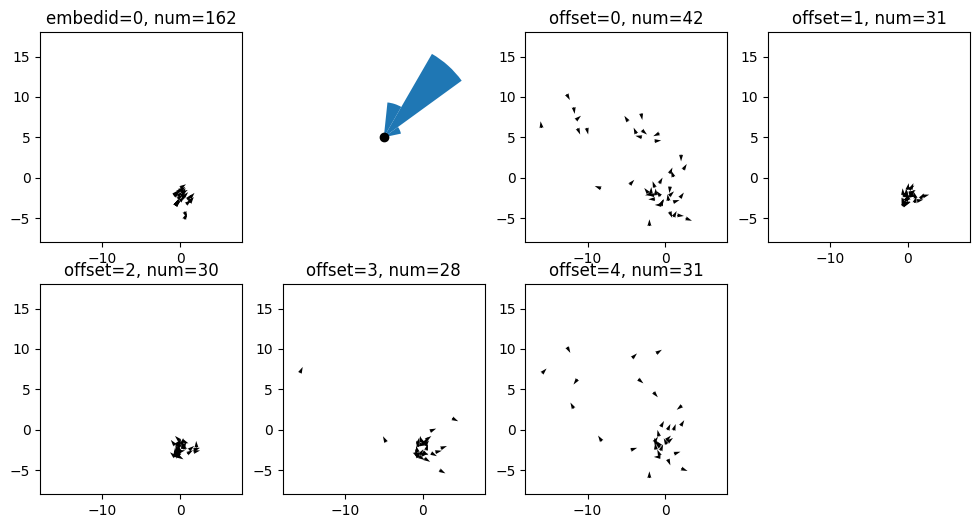

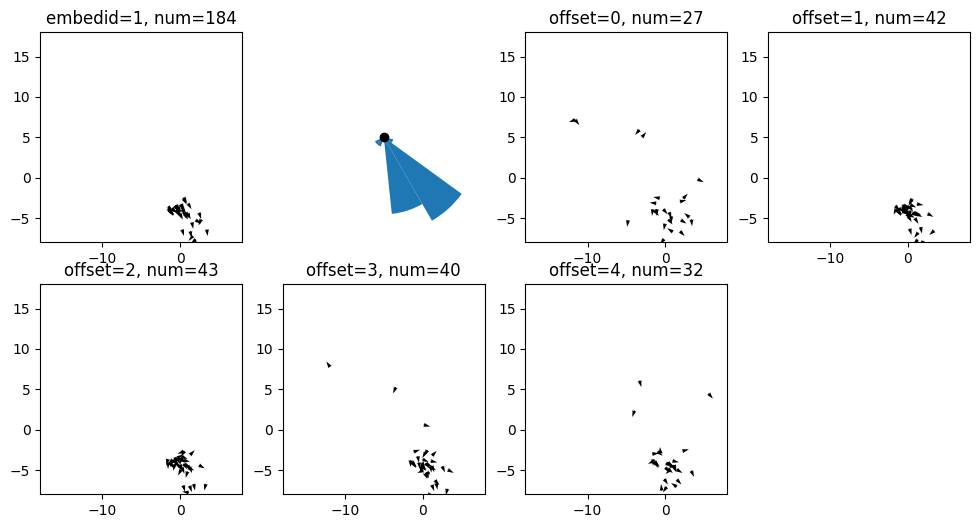

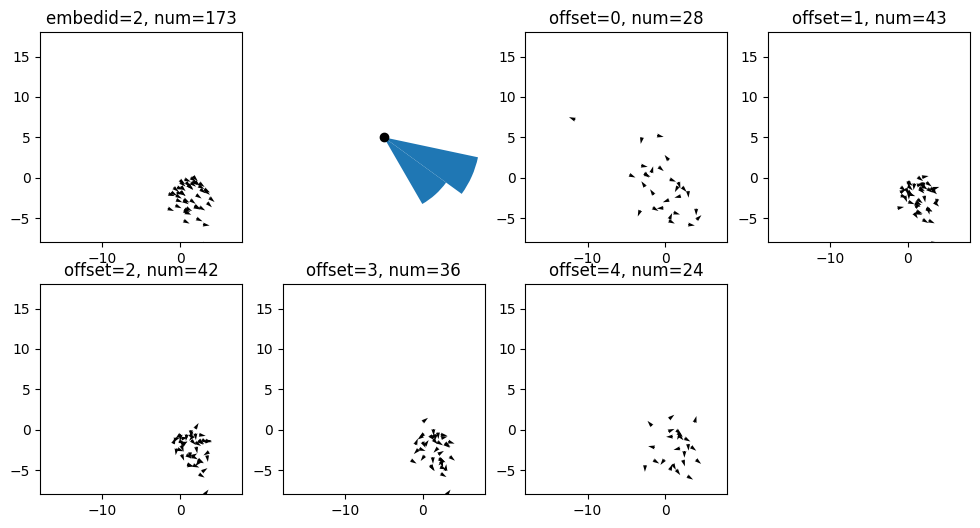

In [39]:
simdf['offset'] = simdf['img_name'].apply(lambda x : int(x.split('.')[0].split('_')[1])) % 5
embeddf = simdf[simdf['img_exist']]
embedids = embeddf['targ_sid'].to_numpy()
predsids = simdf['pred_sid'].to_numpy()
unique_embedids = np.unique(embedids)

print(f'Num unique states = {unique_embedids.shape[0]}')
aedges = np.linspace(-np.pi, np.pi, 16)

xbound = (-18, 8)
ybound = (-8, 18)

for i, embedid_each in enumerate(unique_embedids):
    subdf = embeddf[embeddf['targ_sid'] == embedid_each]
    xya_targs = subdf[['x', 'y', 'a']].to_numpy()
    subsimdf = simdf[simdf['pred_sid'] == embedid_each]
    xya_pred = subsimdf[['x', 'y', 'a']].to_numpy()
    pred_offsets = subsimdf['offset'].to_numpy()
    title = f'embedid={embedid_each}, num={xya_pred.shape[0]}'
    compare_spatial_specificity(xya_targs, xya_pred, pred_offsets, aedges, xbound, ybound, title=title)
    if i > 1:
        break
    
    
    